## Loading the files needed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr

# --- Load Financial News Data ---
news_file = "tesla_financial_news_january.xlsx"
df_news = pd.read_excel(news_file, sheet_name="Sheet1")

# Convert Date column to datetime format
df_news["Date"] = pd.to_datetime(df_news["Date"]).dt.date


df_stock = pd.read_excel('tesla_stock_prices.xlsx', sheet_name="Sheet1")

df_stock["Price_Change"] = df_stock["Close"] - df_stock["Open"]
df_stock["Percent_Change"] = (df_stock["Price_Change"] / df_stock["Open"]) * 100

In [4]:
df_news.head()

,Date,Title,Content,Source,URL
0,2025-01-01,5 Nasdaq Stocks Hitting New 52-Week Highs At Y...,"Nasdaq, new highs\r\ngetty\r\nApple, Amazon an...",Forbes,https://www.forbes.com/sites/johnnavin/2024/12...
1,2025-01-01,The Rich Stop Paying Social Security Tax Aroun...,"BROWNSVILLE, TEXAS - NOVEMBER 19: U.S. Preside...",Forbes,https://www.forbes.com/sites/teresaghilarducci...
2,2025-01-01,Musk says 'whole Tesla senior team' probing Cy...,"Earnings calls, analyst events, roadshows and ...",Thefly.com,https://thefly.com/permalinks/entry.php/id4044...
3,2025-01-01,Bard Financial Services Inc. Reduces Stock Pos...,Bard Financial Services Inc. trimmed its posit...,ETF Daily News,https://www.etfdailynews.com/2025/01/01/bard-f...
4,2025-01-01,ASML STOCK UPDATE: ASML Holding Investors are ...,"NEW YORK, Jan. 01, 2025 (GLOBE NEWSWIRE) -- Le...",GlobeNewswire,https://www.globenewswire.com/news-release/202...


In [5]:
df_stock.head()

,Date,Open,Close,Difference,Price_Change,Percent_Change
0,2025-01-02,390.100006,379.279999,-10.820007,-10.820007,-2.773650
1,2025-01-03,381.480011,410.440002,28.959991,28.959991,7.591483
2,2025-01-06,423.200012,411.049988,-12.150024,-12.150024,-2.870989
3,2025-01-07,405.829987,394.359985,-11.470001,-11.470001,-2.826307
4,2025-01-08,392.950012,394.940002,1.989990,1.989990,0.506423


In [13]:
import boto3
import pandas as pd
import json
from datetime import datetime
import re

def get_bedrock_client():
    """Initialize and return the Bedrock client"""
    return boto3.client(
        service_name='bedrock-runtime',
        region_name='us-west-2'  
    )



def extract_number(text):
    """Extract and round the first number to -1, 0, or 1."""
    match = re.search(r'-?\d+\.?\d*', text)  # Find any number
    if match:
        number = float(match.group(0))  # Convert to float
        return int(max(-1, min(1, round(number))))  # Round & constrain to -1, 0, 1

    raise ValueError(f"Could not extract a valid number from response: {text}")

def calculate_importance(row, bedrock_client):
    """Calculate importance score for a news article using Claude"""
    prompt = f"""Human:Analyze this financial news article and rate its importance on a scale of 0 to 10.
    Consider these factors:
    1. Source credibility (e.g., Forbes = high, blog = lower)
    2. Content relevance to financial markets
    3. Title impact and newsworthiness
    4. Potential market impact
    
    Source: {row['Source']}
    Title: {row['Title']}
    Content: {row['Content']}
    
    Provide only a single number between 0 and 10, where:
    0-2: Very low importance
    3-4: Low importance
    5-6: Moderate importance
    7-8: High importance
    9-10: Very high importance

    Remember: Respond with ONLY the number. No words or explanations.
    
    Assistant: """

    body = json.dumps({
        "prompt": prompt,
        "max_tokens_to_sample": 100,
        "temperature": 0,
        "anthropic_version": "bedrock-2023-05-31"
    })
    
    response = bedrock_client.invoke_model(
        modelId='anthropic.claude-v2',  
        body=body
    )
    
    response_body = json.loads(response['body'].read())
    importance_score = float(response_body['completion'].strip())
    return importance_score
        

def calculate_sentiment(row, bedrock_client):
    """Calculate sentiment score (-1, 0, 1) for a news article using Claude."""
    prompt = f"""Human: Analyze the sentiment of this financial news article and rate it as:
    -1 for negative sentiment
    0 for neutral sentiment
    1 for positive sentiment

    Title: {row['Title']}
    Content: {row['Content']}

    Ensure you appropriately rate them 1 or -1, try to avoid 0.
    Respond with ONLY a single number (-1, 0, or 1), nothing else.
    
    Assistant: """

    body = json.dumps({
        "prompt": prompt,
        "max_tokens_to_sample": 100,
        "temperature": 0,
        "anthropic_version": "bedrock-2023-05-31"
    })

    response = bedrock_client.invoke_model(
        modelId='anthropic.claude-v2',  
        body=body
    )

    response_body = json.loads(response['body'].read())
    raw_text = response_body['completion'].strip()

    #print(f"Claude response: {raw_text}")  # Debugging: Print raw output

    try:
        return extract_number(raw_text)
    except ValueError:
        print(f"Unexpected response: {raw_text}. Defaulting to 0.")
        return 0  # Default to neutral if extraction fails

def process_dataframes(news_df, price_df):
    """Process and combine the news and price dataframes"""
    # Initialize Bedrock client
    bedrock_client = get_bedrock_client()
    
    # Convert date columns to datetime if they aren't already
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    
    # Calculate importance and sentiment scores
    print("Calculating importance scores...")
    news_df['importance'] = news_df.apply(lambda row: calculate_importance(row, bedrock_client), axis=1)
    
    print("Calculating sentiment scores...")
    news_df['sentiment'] = news_df.apply(lambda row: calculate_sentiment(row, bedrock_client), axis=1)
    
    # Merge dataframes on date
    combined_df = pd.merge(
        news_df,
        price_df,
        on='Date',
        how='inner'
    )
    
    # Sort by date and importance
    combined_df = combined_df.sort_values(['Date', 'importance'], ascending=[True, False])
    
    return combined_df



In [14]:
#create the resulting dataframe 
result_df = process_dataframes(df_news, df_stock)
    
# Save the results
result_df.to_csv('analyzed_financial_news.csv', index=False)
    
print("Analysis complete! Results saved to 'analyzed_financial_news.csv'")

Calculating importance scores...
Calculating sentiment scores...
Claude response: 1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: -1
Claude response: 1
Claude response: 0
Claude response: 1
Claude response: 1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: -1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 1
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Claude response: 0
Cl

In [15]:
result_df.head()

,Date,Title,Content,Source,URL,importance,sentiment,Open,Close,Difference,Price_Change,Percent_Change
3,2025-01-02,Funds Scoop This Winner With Tesla-Like Gains;...,Not many stocks can boast the kind of gains th...,Investor's Business Daily,https://www.investors.com/stock-lists/stock-sp...,8.0,1,390.100006,379.279999,-10.820007,-10.820007,-2.77365
4,2025-01-02,Tesla Deliveries Are Due. Analysts Expect A Re...,Tesla (TSLA) will report fourth-quarter and fu...,Investor's Business Daily,https://www.investors.com/news/tesla-deliverie...,8.0,0,390.100006,379.279999,-10.820007,-10.820007,-2.77365
0,2025-01-02,Tesla Q4 Vehicle Deliveries Fall Short Of Esti...,Tesla did not meet expectations in its first m...,Forbes,https://www.forbes.com/sites/dereksaul/2025/01...,7.0,0,390.100006,379.279999,-10.820007,-10.820007,-2.77365
1,2025-01-02,Magnificent Seven Stocks: Nvidia Rebounds; Tes...,"Dubbed the Magnificent Seven stocks, Apple, Mi...",Investor's Business Daily,https://www.investors.com/research/magnificent...,7.0,0,390.100006,379.279999,-10.820007,-10.820007,-2.77365
2,2025-01-02,Tesla reports first annual decline in deliveries,Tesla posted its fourth-quarter vehicle produc...,NBC News,https://www.nbcnews.com/business/autos/tesla-r...,7.0,-1,390.100006,379.279999,-10.820007,-10.820007,-2.77365


In [ ]:
results_df=pd.read_csv('analyzed_financial_news.csv')

## Validate assumptions - firstly, check for stationarity

In [16]:
!pip install pandas numpy statsmodels


# Select relevant columns (ensure they are numerical)
df = result_df[["Date", "sentiment", "Price_Change"]]


from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Series is non-stationary. Differencing may be needed.")
    else:
        print("Series is stationary.")

# Check stationarity
check_stationarity(df["sentiment"])
check_stationarity(df["Price_Change"])


ADF Statistic: -4.850203793383407
p-value: 4.3553415612360236e-05
Series is stationary.
ADF Statistic: -3.3332530074388282
p-value: 0.01345593880236296
Series is stationary.


## Check for lagged correlation - Cross-Correlation Analysis

Stock prices may react delayed to news. We can check for lagged correlation.

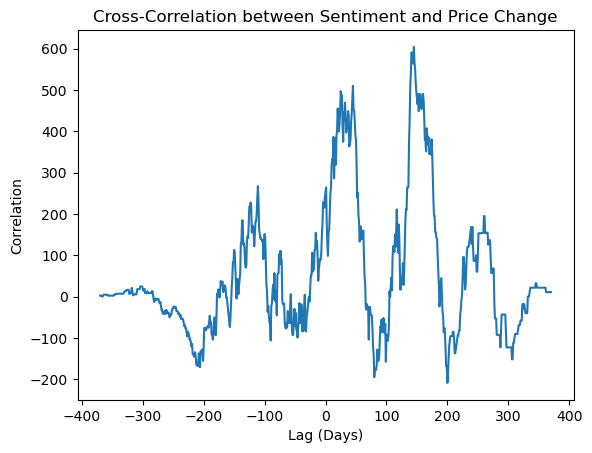

In [18]:
import numpy as np

# Compute cross-correlation
cross_corr = np.correlate(df["sentiment"], df["Price_Change"], mode="full")

# Plot cross-correlation
import matplotlib.pyplot as plt

lags = np.arange(-len(df)+1, len(df))  # Lag values
plt.plot(lags, cross_corr)
plt.title("Cross-Correlation between Sentiment and Price Change")
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.show()


Interpretation: Correlation peaks at positive lags, therefore sentiment leads stock movements.

In [23]:
df["sentiment"].value_counts()

sentiment
 0    289
 1     70
-1     12
Name: count, dtype: int64

In [27]:
df["sentiment_rolling"] = df["sentiment"].rolling(7).mean()

# Option 1: Fill NaNs with a default value (e.g., 0)
df["sentiment_rolling"].fillna(0, inplace=True)

# Option 2: Drop rows with NaN values (if you want to avoid distorting the analysis)
df.dropna(subset=["sentiment_rolling"], inplace=True)


/tmp/ipykernel_21923/2684806302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment_rolling"] = df["sentiment"].rolling(7).mean()
/tmp/ipykernel_21923/2684806302.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["sentiment_rolling"].fillna(0, inplace=True)
/tmp/ipykern

In [28]:
df.head()

,Date,sentiment,Price_Change,price_movement,price_direction,sentiment_rolling
3,2025-01-02,1,-10.820007,Down,0,0.0
4,2025-01-02,0,-10.820007,Down,0,0.0
0,2025-01-02,0,-10.820007,Down,0,0.0
1,2025-01-02,0,-10.820007,Down,0,0.0
2,2025-01-02,-1,-10.820007,Down,0,0.0


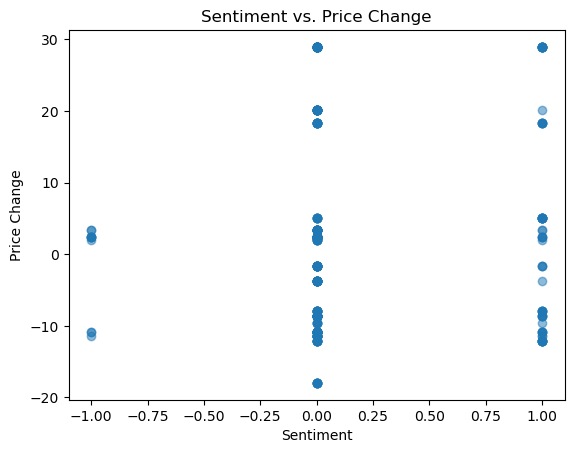

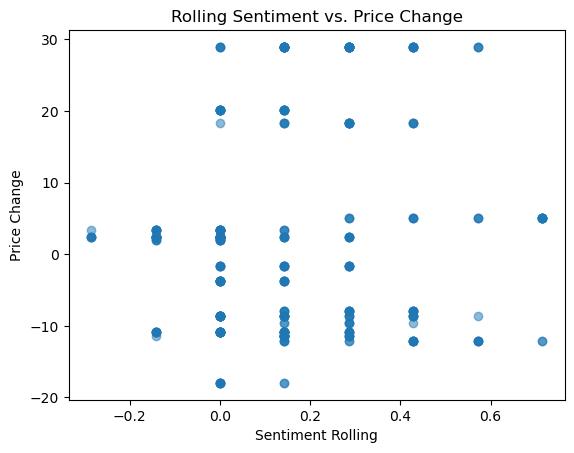

In [29]:
import matplotlib.pyplot as plt

# Plot sentiment vs. price change
plt.scatter(df["sentiment"], df["Price_Change"], alpha=0.5)
plt.title("Sentiment vs. Price Change")
plt.xlabel("Sentiment")
plt.ylabel("Price Change")
plt.show()

# Plot rolling sentiment vs. price change
plt.scatter(df["sentiment_rolling"], df["Price_Change"], alpha=0.5)
plt.title("Rolling Sentiment vs. Price Change")
plt.xlabel("Sentiment Rolling")
plt.ylabel("Price Change")
plt.show()
